In [1]:
%matplotlib inline
from collections import defaultdict

import matplotlib.pylab as plt
from skimpy import skim
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns


In [2]:

import tensorflow as tf
import tensorflow_probability as tfp

from bayesianquilts.models.logistic_regression import LogisticRegression
from bayesianquilts.metrics.classification import classification_metrics

2024-01-04 02:42:48.785363: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-04 02:42:48.811374: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 02:42:48.811406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 02:42:48.812630: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 02:42:48.817765: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-04 02:42:48.818596: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
print(tf.__version__, tfp.__version__)

2.15.0 0.23.0


# Load the dataset

Using the example from here: https://www.tensorflow.org/guide/core/logistic_regression_core

In [4]:
from ucimlrepo import fetch_ucirepo 


In [5]:
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets 

In [6]:
X_scaled = (X - X.min())/X.max()
n = X_scaled.shape[0]
p = X_scaled.shape[1]

In [7]:
lr_model = LogisticRegression(dim_regressors=p, regression_interact=None)

In [8]:
batch_size = 1057


In [9]:
tfdata = tf.data.Dataset.from_tensor_slices({'X': X_scaled, 'y':y})

def data_factory():
    out = tfdata.shuffle(batch_size*10).batch(batch_size)
    return out

In [10]:
losses = lr_model.fit(
    data_factory,
    dataset_size=n,
    batches_per_step=1,
    check_every=int(n/batch_size),
    batch_size=batch_size,
    num_steps=4000,
    max_decay_steps=100,
    max_plateau_epochs=100,
    sample_size=32,
    learning_rate=0.0015)

Running optimization for 4000 steps of 1 accumulated batches, checking every 240 steps
Saved a checkpoint: /tmp/tfcheckpoints/5bd42b7c-5b6a-4dcd-a0c0-1bd856f476a9/5bd42b7c-5b6a-4dcd-a0c0-1bd856f476a9-1


  0%|          | 0/4000 [00:00<?, ?it/s]

  6%|▌         | 236/4000 [00:03<00:42, 87.78it/s]

Step 240: average-batch loss:432.2113182393455 rel loss: 2.3136830476203087e+305
Saved a checkpoint: /tmp/tfcheckpoints/5bd42b7c-5b6a-4dcd-a0c0-1bd856f476a9/5bd42b7c-5b6a-4dcd-a0c0-1bd856f476a9-2


 12%|█▏        | 471/4000 [00:06<00:40, 86.18it/s]

Step 480: average-batch loss:398.9174034027828 rel loss: 0.08346067269205142
Saved a checkpoint: /tmp/tfcheckpoints/5bd42b7c-5b6a-4dcd-a0c0-1bd856f476a9/5bd42b7c-5b6a-4dcd-a0c0-1bd856f476a9-3


 18%|█▊        | 716/4000 [00:08<00:38, 86.25it/s]

Step 720: average-batch loss:436.20189129643825 rel loss: 0.08547530085860476
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 24%|██▍       | 951/4000 [00:11<00:35, 85.84it/s]

Step 960: average-batch loss:408.3073790235468 rel loss: 0.02299732040900121
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 30%|██▉       | 1195/4000 [00:14<00:32, 86.30it/s]

Step 1200: average-batch loss:390.84267893245146 rel loss: 0.02065978181396832
Saved a checkpoint: /tmp/tfcheckpoints/5bd42b7c-5b6a-4dcd-a0c0-1bd856f476a9/5bd42b7c-5b6a-4dcd-a0c0-1bd856f476a9-4


 36%|███▌      | 1439/4000 [00:17<00:29, 86.01it/s]

Step 1440: average-batch loss:400.15322969592944 rel loss: 0.02326746374270908
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 42%|████▏     | 1673/4000 [00:19<00:26, 88.06it/s]

Step 1680: average-batch loss:399.7165201224305 rel loss: 0.022200336346521365
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 48%|████▊     | 1917/4000 [00:22<00:24, 85.78it/s]

Step 1920: average-batch loss:371.34531873501555 rel loss: 0.05250466133208166
Saved a checkpoint: /tmp/tfcheckpoints/5bd42b7c-5b6a-4dcd-a0c0-1bd856f476a9/5bd42b7c-5b6a-4dcd-a0c0-1bd856f476a9-5


 54%|█████▍    | 2152/4000 [00:25<00:20, 88.15it/s]

Step 2160: average-batch loss:440.2280764306798 rel loss: 0.15647061462812176
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 60%|█████▉    | 2396/4000 [00:28<00:18, 85.46it/s]

Step 2400: average-batch loss:406.54258239913963 rel loss: 0.08657706520289611
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 66%|██████▌   | 2639/4000 [00:31<00:15, 86.77it/s]

Step 2640: average-batch loss:391.19646518256206 rel loss: 0.05074469790590377
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 72%|███████▏  | 2873/4000 [00:33<00:13, 86.61it/s]

Step 2880: average-batch loss:402.33757852802563 rel loss: 0.07703048744886565
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 78%|███████▊  | 3116/4000 [00:36<00:10, 85.90it/s]

Step 3120: average-batch loss:399.40748715832535 rel loss: 0.07025949519115034
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 84%|████████▍ | 3351/4000 [00:39<00:07, 86.60it/s]

Step 3360: average-batch loss:389.5542642737331 rel loss: 0.046743027117583914
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 90%|████████▉ | 3594/4000 [00:42<00:04, 86.48it/s]

Step 3600: average-batch loss:360.08906122046915 rel loss: 0.03125964858914339
Saved a checkpoint: /tmp/tfcheckpoints/5bd42b7c-5b6a-4dcd-a0c0-1bd856f476a9/5bd42b7c-5b6a-4dcd-a0c0-1bd856f476a9-6


 96%|█████████▌| 3837/4000 [00:45<00:01, 85.07it/s]

Step 3840: average-batch loss:409.6273936754295 rel loss: 0.12093510644020145
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


100%|█████████▉| 3999/4000 [00:46<00:00, 85.74it/s]

Terminating because we are out of iterations


100%|██████████| 4000/4000 [00:46<00:00, 85.22it/s]


# Compute LOO AU ROC/PRC

In [11]:
def prediction_fn_stepaway(data):
    params = lr_model.sample(100)
    pred = lr_model.stepaway_loo(data, params, 0.0001)['p_loo_stepaway']
    return pred

def prediction_fn_loo(data):
    params = lr_model.sample(100)
    pred = lr_model.stepaway_loo(data, params, 0.0001)['p_loo']
    return pred

def prediction_fn(data):
    params = lr_model.sample(100)
    pred = lr_model.stepaway_loo(data, params, 0.0001)['p']
    return pred

In [12]:
bench_stepaway_loo = classification_metrics(
    data_factory=data_factory,
    prediction_fn=prediction_fn_stepaway,
    outcome_label='y',
    by_vars=[]
)

bench_loo = classification_metrics(
    data_factory=data_factory,
    prediction_fn=prediction_fn_loo,
    outcome_label='y',
    by_vars=[]
)

bench = classification_metrics(
    data_factory=data_factory,
    prediction_fn=prediction_fn,
    outcome_label='y',
    by_vars=[]
)

(0.0, 1.0)

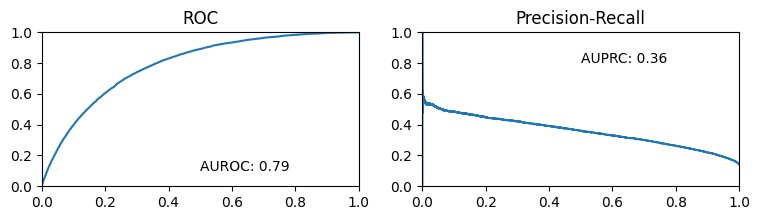

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_stepaway_loo['auroc']['fpr'], bench_stepaway_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_stepaway_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_stepaway_loo['auprc']['recall'], bench_stepaway_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_stepaway_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

(0.0, 1.0)

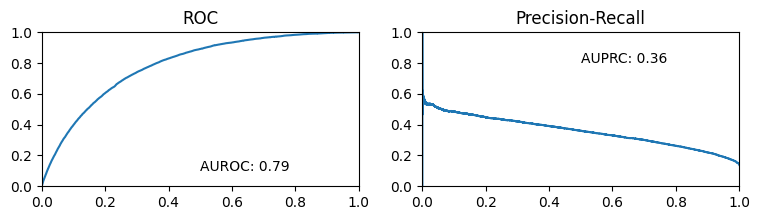

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_loo['auroc']['fpr'], bench_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_loo['auprc']['recall'], bench_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

(0.0, 1.0)

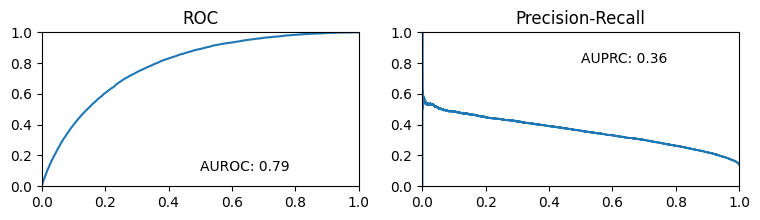

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench['auroc']['fpr'], bench['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench['auprc']['recall'], bench['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

In [16]:
bench['auroc']['auroc']

0.7894034574667436